In [100]:
import numpy as np
from graphviz import Digraph

In [199]:
class Variable:
    count = 0
    def __init__(self, value, parents=(), op=''):
        self.value = value if isinstance(value, np.ndarray) else np.array(value, dtype=np.float64)
        self.input_size = self.value.shape
        self.grad = np.zeros(self.input_size)
        self.parents = set(parents)
        self.op = op       # parent operation
        self.backward_step = lambda: None
        self.name = 'x_' + str(Variable.count)
        Variable.count += 1
    
    def __repr__(self):
        return f"Variable(value={self.value}, grad={self.grad}, name=\"{self.name}\", op=\"{self.op}\", n_parents={len(self.parents)})"

    def __add__(self, other):
        assert isinstance(other, (int, float, Variable)), "invalid data type"
        if not isinstance(other, Variable):
            data = np.empty(self.input_size)
            data.fill(other)
            other = Variable(data)
            
        out = Variable(self.value + other.value, (self, other), op='+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
            
        out.backward_step = _backward
        return out

    def __radd__(self, other):
        assert isinstance(other, (int, float, Variable)), "invalid data type"
        if not isinstance(other, Variable):
            data = np.empty(self.input_size)
            data.fill(other)
            other = Variable(data)
            
        out = Variable(self.value + other.value, (self, other), op='+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
            
        out.backward_step = _backward
        return out

    def __mul__(self, other):
        assert isinstance(other, (int, float, Variable)), "invalid data type"
        if not isinstance(other, Variable):
            data = np.empty(self.input_size)
            data.fill(other)
            other = Variable(data)
            
        out = Variable(self.value * other.value, (self, other), op='*')
        
        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad

        out.backward_step = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, number):
        assert isinstance(number, (int, float)), "only supporting int/float powers"
        out = Variable(np.power(self.value, number), (self,), op=f'^{number}')

        def _backward():
            self.grad += out.grad * (number * self.value ** (number - 1))

        out.backward_step = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        assert isinstance(other, (int, float, Variable)), "invalid data type"
        if not isinstance(other, Variable):
            data = np.empty(self.input_size)
            data.fill(other)
            other = Variable(data)
            
        out = Variable(self.value - other.value, (self, other), op='-')
        
        def _backward():
            self.grad += out.grad
            other.grad -= out.grad

        out.backward_step = _backward
        return out

    def __rsub__(self, other):
        return other - self

    def __truediv__(self, other):
        assert isinstance(other, (int, float, Variable)), "invalid data type"
        if not isinstance(other, Variable):
            data = np.empty(self.input_size)
            data.fill(other)
            other = Variable(data)
            
        return self * other ** -1

    def __rtruediv__(self, other):
        assert isinstance(other, (int, float, Variable)), "invalid data type"
        if not isinstance(other, Variable):
            data = np.empty(self.input_size)
            data.fill(other)
            other = Variable(data)
            
        return other * self ** -1

    def sin(self):
        out = Variable(np.sin(self.value), (self,), op='sin')

        def _backward():
            self.grad += out.grad * np.cos(self.value)

        out.backward_step = _backward
        return out

    def cos(self):
        out = Variable(np.cos(self.value), (self,), op='cos')

        def _backward():
            self.grad -= np.sin(self.value) * out.grad

        out.backward_step = _backward
        return out

    def tan(self):
        return self.sin() / self.cos()

    def log(self):
        out = Variable(np.log(self.value), (self,), op='log')

        def _backward():
            self.grad += (1 / self.value) * out.grad

        out.backward_step = _backward
        return out
    
    def exp(self):
        out = Variable(np.exp(self.value), (self,), op='exp')

        def _backward():
            self.grad += out.grad * np.exp(self.value)

        out.backward_step = _backward
        return out

    def relu(self):
        out = Variable(np.maximum(np.zeros(self.input_size), self.value), (self,), op='relu')

        def _backward():
            self.grad += out.grad * (out.value > 0)

        out.backward_step = _backward
        return out
        
    def topsort(self):
        sorted_nodes = []
        visited = set()
        
        def dfs(v):
            if v in visited:
                return
            visited.add(v)
            for nei in v.parents:
                dfs(nei)
            sorted_nodes.append(v)
            
        dfs(self)
        return sorted_nodes

    def backward(self):
        topo = self.topsort()
        self.grad = np.empty(self.input_size)
        self.grad.fill(1.0)

        for node in reversed(topo):
            print(node)
            node.backward_step()

    def build_graph(self):
        edges, nodes = set(), set()

        def dfs(v):
            if v not in nodes:
                nodes.add(v)
                for nei in v.parents:
                    edges.add((nei, v))
                    dfs(nei)
            
        dfs(self)
        return nodes, edges

In [200]:
def draw_dag_forward(root, rankdir='LR'):
    assert rankdir in ['LR', 'TB']
    # Compute the nodes and edges using the `trace` function we just
    # described in the `Variable` class.
    nodes, edges = root.build_graph()

    # A diagraph is the kind of visualization we're after.
    # Format is the output type. You can change this to png, jpeg, etc.
    # Rankdir must be either LR (left-to-right) or TB (top-to-bottom)
    dot = Digraph(format='svg', graph_attr={'rankdir': rankdir})
    
    for n in nodes: # For each node
        # Add a node with the machine name of this object
        # There are many kinds of shapes available; https://graphviz.org/doc/info/shapes.html
        # We will use the 'record' shape containing the primal and tangent value rounded
        # to 3 digits.
        dot.node(name=str(id(n)), label = "{%s = %s}" % (n.name, n.value), shape='record')
        if n.op: # If this is an op (as in the name op is not empty)
            # Add a node and name it the machine name + the op
            dot.node(name=str(id(n)) + n.op, label=n.op)
            # Connect an edge between this newly created op and the parent node
            dot.edge(str(id(n)) + n.op, str(id(n)))
    
    for n1, n2 in edges: # For the nodes in each edge
        # Add an edge
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    
    # Return the graph
    return dot

def draw_dag_backward(root, rankdir='RL'):
    assert rankdir in ['LR', 'RL', 'TB']
    # Compute the nodes and edges using the `trace` function we just
    # described in the `Variable` class.
    nodes, edges = root.build_graph()

    # A diagraph is the kind of visualization we're after.
    # Format is the output type. You can change this to png, jpeg, etc.
    # Rankdir must be either LR (left-to-right) or TB (top-to-bottom)
    dot = Digraph(format='png', graph_attr={'rankdir': rankdir})
    
    for n in nodes: # For each node
        # Add a node with the machine name of this object
        # There are many kinds of shapes available; https://graphviz.org/doc/info/shapes.html
        # We will use the 'record' shape containing the primal and tangent value rounded
        # to 3 digits.
        dot.node(name=str(id(n)), label = "{d%s/d%s = %s} | {%s = %s}" % (root.name, n.name, n.grad, n.name, n.value), shape='record')
        if n.op: # If this is an op (as in the name op is not empty)
            # Add a node and name it the machine name + the op
            dot.node(name=str(id(n)) + n.op, label=n.op)
            # Connect an edge between this newly created op and the parent node
            dot.edge(str(id(n)),str(id(n)) + n.op)
    
    for n1, n2 in edges: # For the nodes in each edge
        # Add an edge
        dot.edge(str(id(n2)) + n2.op,str(id(n1)))
    
    # Return the graph
    return dot

In [201]:
x1 = Variable([2, 3])
x2 = Variable([5, 0.225])

y = (x1 - x2) ** 2 / 2

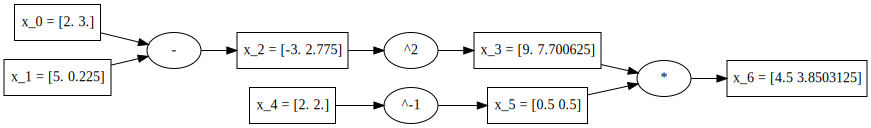

In [202]:
draw_dag_forward(y)

In [203]:
y.backward()

Variable(value=[4.5       3.8503125], grad=[1. 1.], name="x_6", op="*", n_parents=2)
Variable(value=[0.5 0.5], grad=[9.       7.700625], name="x_5", op="^-1", n_parents=1)
Variable(value=[2. 2.], grad=[-2.25       -1.92515625], name="x_4", op="", n_parents=0)
Variable(value=[9.       7.700625], grad=[0.5 0.5], name="x_3", op="^2", n_parents=1)
Variable(value=[-3.     2.775], grad=[-3.     2.775], name="x_2", op="-", n_parents=2)
Variable(value=[5.    0.225], grad=[ 3.    -2.775], name="x_1", op="", n_parents=0)
Variable(value=[2. 3.], grad=[-3.     2.775], name="x_0", op="", n_parents=0)


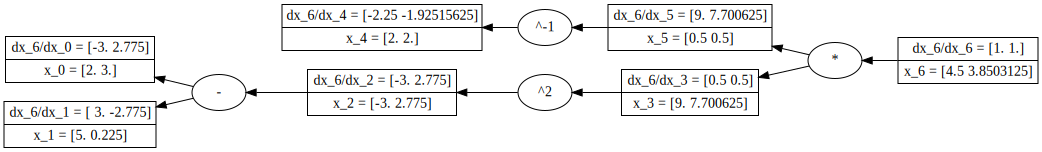

In [204]:
draw_dag_backward(y)

In [210]:
a = Variable([[2., 3.], [9., 4.]])
b = Variable([[6., 4.], [7., 1.]])

Q = 3*a**3 - b**2
Q.name = 'Q'

In [211]:
Q

Variable(value=[[ -12.   65.]
 [2138.  191.]], grad=[[0. 0.]
 [0. 0.]], name="Q", op="-", n_parents=2)

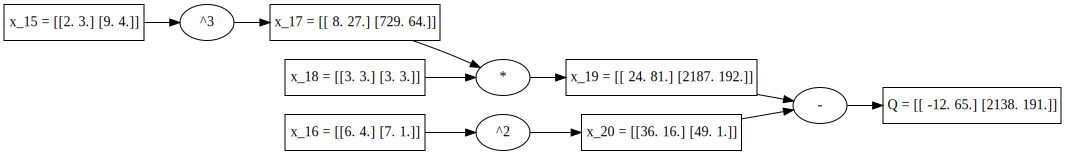

In [212]:
draw_dag_forward(Q)

In [213]:
Q.backward()

Variable(value=[[ -12.   65.]
 [2138.  191.]], grad=[[1. 1.]
 [1. 1.]], name="Q", op="-", n_parents=2)
Variable(value=[[  24.   81.]
 [2187.  192.]], grad=[[1. 1.]
 [1. 1.]], name="x_19", op="*", n_parents=2)
Variable(value=[[  8.  27.]
 [729.  64.]], grad=[[3. 3.]
 [3. 3.]], name="x_17", op="^3", n_parents=1)
Variable(value=[[2. 3.]
 [9. 4.]], grad=[[ 36.  81.]
 [729. 144.]], name="x_15", op="", n_parents=0)
Variable(value=[[3. 3.]
 [3. 3.]], grad=[[  8.  27.]
 [729.  64.]], name="x_18", op="", n_parents=0)
Variable(value=[[36. 16.]
 [49.  1.]], grad=[[-1. -1.]
 [-1. -1.]], name="x_20", op="^2", n_parents=1)
Variable(value=[[6. 4.]
 [7. 1.]], grad=[[-12.  -8.]
 [-14.  -2.]], name="x_16", op="", n_parents=0)


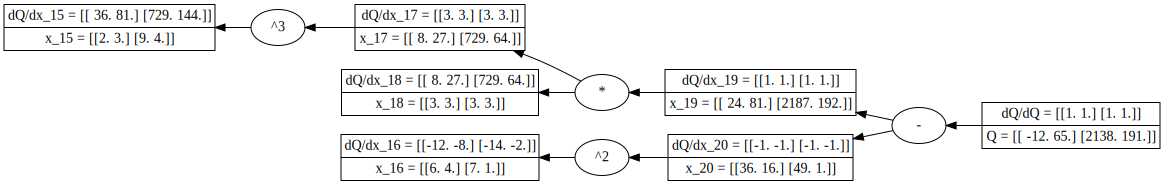

In [214]:
draw_dag_backward(Q)

In [215]:
c = torch.tensor([[2., 3.], [9., 4.]], requires_grad=True)
d = torch.tensor([[6., 4.], [7., 1.]], requires_grad=True)

P = 3*c**3 - d**2

In [217]:
external_grad = torch.tensor([[1., 1.], [1., 1,]])
P.backward(gradient=external_grad)

In [218]:
c.grad

tensor([[ 36.,  81.],
        [729., 144.]])

In [219]:
d.grad

tensor([[-12.,  -8.],
        [-14.,  -2.]])